In [83]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [84]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

In [86]:
Ldata = pd.read_csv("C:/Users/JANANI V/Desktop/MDP/Indian_Liver_patient.csv")
Kdata = pd.read_csv("C:/Users/JANANI V/Desktop\MDP/kidney_disease.csv")
Pdata = pd.read_csv("C:/Users/JANANI V/Desktop/MDP/parkinsons.csv")


In [87]:
Ldata.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [88]:
Ldata.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [89]:

# Identify rows where 'Albumin_and_Globulin_Ratio' is missing
missing_indices = Ldata[Ldata["Albumin_and_Globulin_Ratio"].isnull()].index

# Loop through missing indices to calculate the A/G Ratio
for idx in missing_indices:
    total_proteins = Ldata.loc[idx, "Total_Protiens"]
    albumin = Ldata.loc[idx, "Albumin"]
    # Ensure required values are non-null
    if pd.notnull(total_proteins) and pd.notnull(albumin):
        globulin = total_proteins - albumin
        if globulin > 0:  # Avoid division by zero or negative globulin
            Ldata.loc[idx, "Albumin_and_Globulin_Ratio"] = albumin / globulin

In [90]:
Ldata.columns = [ col.lower().replace(" ","_") for col in Ldata.columns]
Ldata.columns

Index(['age', 'gender', 'total_bilirubin', 'direct_bilirubin',
       'alkaline_phosphotase', 'alamine_aminotransferase',
       'aspartate_aminotransferase', 'total_protiens', 'albumin',
       'albumin_and_globulin_ratio', 'dataset'],
      dtype='object')

In [91]:
Ldata = Ldata.drop(columns=['gender'])

In [92]:

# Convert target labels: Change 1 → 0 (No disease) and 2 → 1 (Liver disease)
Ldata['dataset'] = Ldata['dataset'].replace({1: 0, 2: 1})
# Verify changes
print(Ldata['dataset'].unique())  # Should output [0, 1]

[0 1]


In [93]:

# Apply SMOTE first
smote = SMOTE(sampling_strategy=1, random_state=42)  
X_liver_smote, y_liver_smote = smote.fit_resample(Ldata.drop(columns=['dataset']), Ldata['dataset'])

# Train-test split
X_train_liver, X_test_liver, y_train_liver, y_test_liver = train_test_split(X_liver_smote, y_liver_smote, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
num_cols = ['age', 'total_bilirubin', 'direct_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase', 
            'aspartate_aminotransferase', 'total_protiens', 'albumin']
X_train_liver[num_cols] = scaler.fit_transform(X_train_liver[num_cols])
X_test_liver[num_cols] = scaler.transform(X_test_liver[num_cols])

print("SMOTE Training Shape:", X_train_liver.shape)

SMOTE Training Shape: (665, 9)


In [94]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
}

# Train models and evaluate
for model_name, model in models.items():
    model.fit(X_train_liver, y_train_liver)
    y_pred = model.predict(X_test_liver)
    print(f"{model_name} Report:\n", classification_report(y_test_liver, y_pred))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.82      0.63      0.71        75
           1       0.75      0.89      0.81        92

    accuracy                           0.77       167
   macro avg       0.79      0.76      0.76       167
weighted avg       0.78      0.77      0.77       167

Random Forest Report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78        75
           1       0.81      0.85      0.83        92

    accuracy                           0.81       167
   macro avg       0.81      0.80      0.81       167
weighted avg       0.81      0.81      0.81       167

XGBoost Report:
               precision    recall  f1-score   support

           0       0.75      0.88      0.81        75
           1       0.89      0.76      0.82        92

    accuracy                           0.81       167
   macro avg       0.82      0.82      0.81       167
weigh

In [95]:
# Define the hyperparameter grid
param_grid_rf = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8],
    'n_estimators': [200, 300, 400]
}

param_grid_xgb = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [4, 6, 8],
    'n_estimators': [200, 300, 400],
    'subsample': [0.7, 0.8, 1.0]
}

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5, 
    n_jobs=-1, 
    scoring='roc_auc',
    verbose=2
)

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid_xgb,
    cv=5, 
    n_jobs=-1, 
    scoring='roc_auc',
    verbose=2
)

# Perform hyperparameter tuning
grid_search_rf.fit(X_train_liver, y_train_liver)
grid_search_xgb.fit(X_train_liver, y_train_liver)

# Print the best hyperparameters and their corresponding score for both models
print("Best Random Forest Hyperparameters:", grid_search_rf.best_params_)
print("Best Random Forest Score:", grid_search_rf.best_score_)
print("Best XGBoost Hyperparameters:", grid_search_xgb.best_params_)
print("Best XGBoost Score:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest Hyperparameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 300}
Best Random Forest Score: 0.859924380287232
Best XGBoost Hyperparameters: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}
Best XGBoost Score: 0.8883436208931734


In [96]:
# Train the XGBoost model with the best hyperparameters
best_xgb = XGBClassifier(
    learning_rate=0.3, 
    max_depth=4, 
    n_estimators=200, 
    subsample=0.7, 
    random_state=42
)

best_xgb.fit(X_train_liver, y_train_liver)

# Get predicted probabilities for class 1
y_probs_xgb = best_xgb.predict_proba(X_test_liver)[:,1]

#compute precision-recall curve tofind the best threshold
precisions, recalls, thresholds = precision_recall_curve(y_test_liver, y_probs_xgb)
best_threshold = thresholds[np.argmax(precisions *recalls)] 
print("Optimal Threshold:", best_threshold)
#Apply this to get final predictions
y_pred_xgb = (y_probs_xgb >= best_threshold).astype(int)

# Evaluate the model
print("\nConfusion Matrix:\n", confusion_matrix(y_test_liver, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test_liver, y_pred_xgb))
print("\nAccuracy Score:", accuracy_score(y_test_liver, y_pred_xgb))

Optimal Threshold: 0.25955406

Confusion Matrix:
 [[60 15]
 [ 9 83]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83        75
           1       0.85      0.90      0.87        92

    accuracy                           0.86       167
   macro avg       0.86      0.85      0.85       167
weighted avg       0.86      0.86      0.86       167


Accuracy Score: 0.8562874251497006


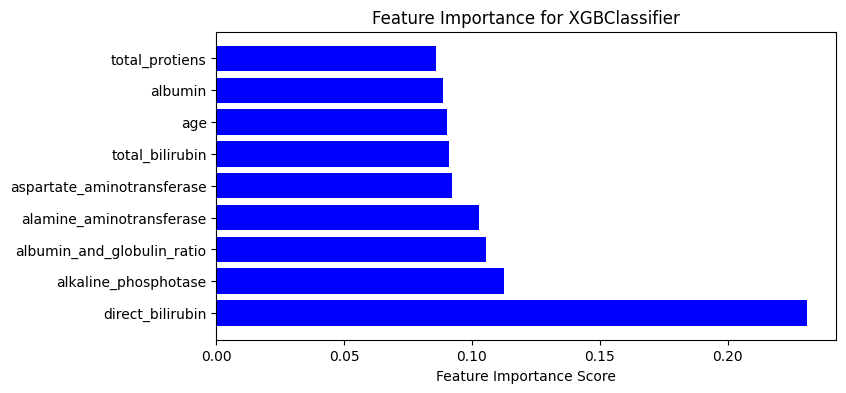

In [97]:
# Analyze Feature Importance (XGBoost)
def plot_feature_importance(model, X_train):
    """Plots feature importance for a trained model."""
    feature_importance = model.feature_importances_
    features = X_train.columns
    plt.figure(figsize=(8, 4))
    indices = np.argsort(feature_importance)[::-1]  # Sort descending
    plt.barh(features[indices], feature_importance[indices], color='blue')
    plt.xlabel("Feature Importance Score")
    plt.title(f"Feature Importance for {model.__class__.__name__}")
    plt.show()

plot_feature_importance(best_xgb, X_train_liver)

In [98]:
import pickle

# Save the trained Liver Disease Prediction model
with open("Liver_prediction_model.pkl", "wb") as file:
    pickle.dump(models["XGBoost"], file)

In [99]:

Pdata.columns = [ col.lower().replace(" ","_") for col in Pdata.columns]
Pdata

,name,mdvp:fo(hz),mdvp:fhi(hz),mdvp:flo(hz),mdvp:jitter(%),mdvp:jitter(abs),mdvp:rap,mdvp:ppq,jitter:ddp,mdvp:shimmer,...,shimmer:dda,nhr,hnr,status,rpde,dfa,spread1,spread2,d2,ppe
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [100]:
Pdata.isnull().sum()

name                0
mdvp:fo(hz)         0
mdvp:fhi(hz)        0
mdvp:flo(hz)        0
mdvp:jitter(%)      0
mdvp:jitter(abs)    0
mdvp:rap            0
mdvp:ppq            0
jitter:ddp          0
mdvp:shimmer        0
mdvp:shimmer(db)    0
shimmer:apq3        0
shimmer:apq5        0
mdvp:apq            0
shimmer:dda         0
nhr                 0
hnr                 0
status              0
rpde                0
dfa                 0
spread1             0
spread2             0
d2                  0
ppe                 0
dtype: int64

In [101]:
X_p = Pdata.drop(columns=['name','status'])  # Remove 'name'
y_p = Pdata['status']  # Target variable

In [102]:
# Check data types of all columns
print(Pdata.dtypes)

name                 object
mdvp:fo(hz)         float64
mdvp:fhi(hz)        float64
mdvp:flo(hz)        float64
mdvp:jitter(%)      float64
mdvp:jitter(abs)    float64
mdvp:rap            float64
mdvp:ppq            float64
jitter:ddp          float64
mdvp:shimmer        float64
mdvp:shimmer(db)    float64
shimmer:apq3        float64
shimmer:apq5        float64
mdvp:apq            float64
shimmer:dda         float64
nhr                 float64
hnr                 float64
status                int64
rpde                float64
dfa                 float64
spread1             float64
spread2             float64
d2                  float64
ppe                 float64
dtype: object


In [103]:
#apply SMOTE
smote = SMOTE(sampling_strategy=1,random_state=42)
X_p_smote,y_p_smote = smote.fit_resample(X_p,y_p)

# train test split 
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_p_smote,y_p_smote,test_size=0.2,random_state=42)

#Scaling
scaler = StandardScaler()
# Get only numerical columns
num_cols = X_p_train.select_dtypes(include=['float64', 'int64']).columns
X_p_train_ss = scaler.fit_transform(X_p_train[num_cols])
X_p_test_ss = scaler.transform(X_p_test[num_cols])

print("SMOTE Training Shape:", X_p_train_ss.shape)

SMOTE Training Shape: (235, 22)


In [104]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
}

# Train models and evaluate
for model_name, model in models.items():
    model.fit(X_p_train_ss, y_p_train)  # Fix target variable reference
    y_pred = model.predict(X_p_test_ss)  # Use correctly scaled test set
    
    print(f"{model_name} Report:\n", classification_report(y_p_test, y_pred))  # Fix test variable reference
    print(f"confusion_matrix:\n", confusion_matrix(y_p_test,y_pred))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       0.87      0.90      0.88        29

    accuracy                           0.88        59
   macro avg       0.88      0.88      0.88        59
weighted avg       0.88      0.88      0.88        59

confusion_matrix:
 [[26  4]
 [ 3 26]]
Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        29

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

confusion_matrix:
 [[30  0]
 [ 0 29]]
XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        29

    accuracy                         

In [105]:
# Set number of folds (e.g., 5)
cv_folds = 5

for model_name, model in models.items():
    scores = cross_val_score(model, X_p_train_ss, y_p_train, cv=cv_folds, scoring='accuracy')
    print(f"{model_name} - Cross Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Logistic Regression - Cross Validation Accuracy: 0.8000 ± 0.0667
Random Forest - Cross Validation Accuracy: 0.9191 ± 0.0159
XGBoost - Cross Validation Accuracy: 0.9319 ± 0.0413


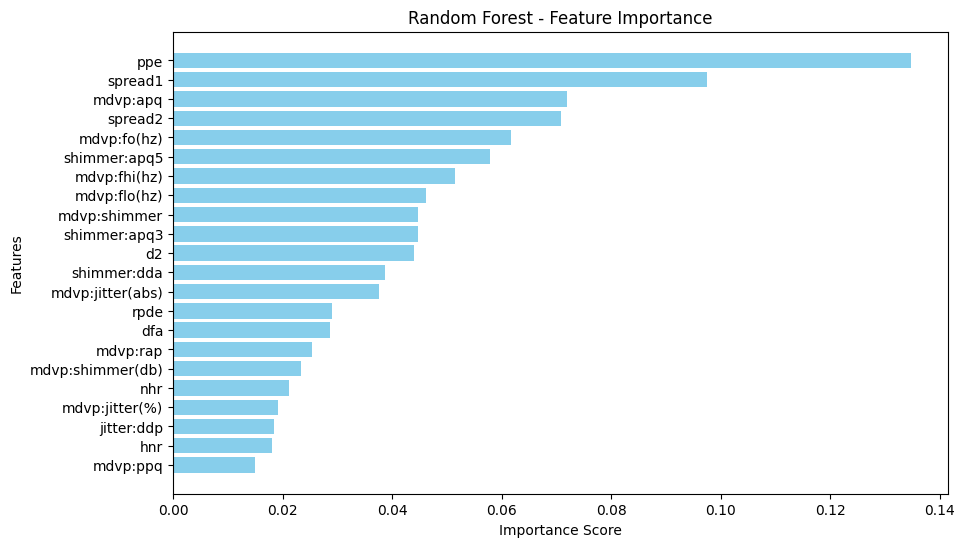

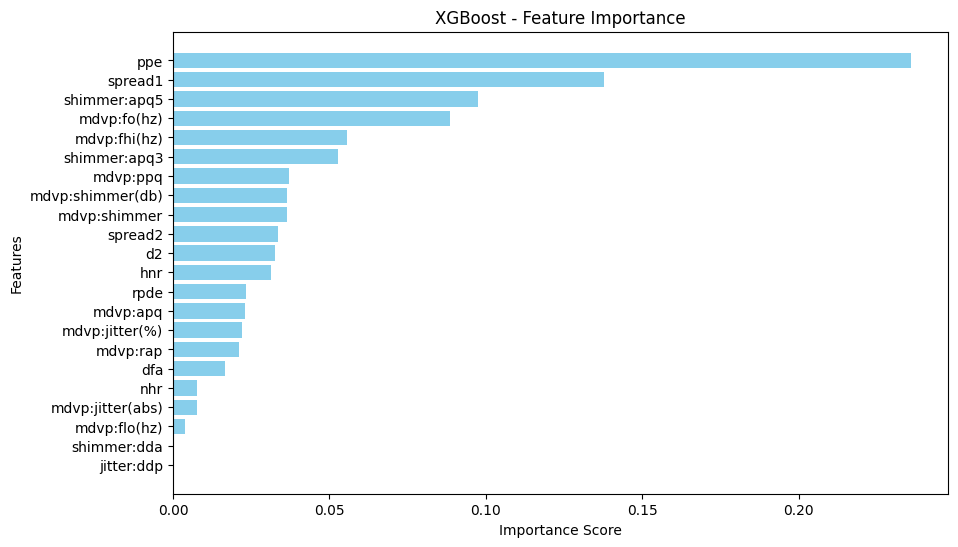

In [106]:
# Create a function to plot feature importance
def plot_feature_importance(model, model_name, X_columns):
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": X_columns, "Importance": importance})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.title(f"{model_name} - Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

# Get feature names from preprocessed data
feature_names = X_p_train.columns

# Random Forest Feature Importance
plot_feature_importance(models["Random Forest"], "Random Forest", feature_names)

# XGBoost Feature Importance
plot_feature_importance(models["XGBoost"], "XGBoost", feature_names)

In [107]:
import pickle
# Save the Parkinson’s-specific trained model
with open("parkinsons_prediction_model.pkl", "wb") as file:
    pickle.dump(models["XGBoost"], file)

In [108]:
Kdata.describe()
Kdata.isnull().sum()

# Handling missing values for numerical columns (using mean)
num_cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
Kdata[num_cols] = Kdata[num_cols].apply(pd.to_numeric, errors='coerce')

Kdata[num_cols] = Kdata[num_cols].fillna(Kdata[num_cols].mean())

# Handling missing values for categorical columns (using mode)
cat_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
for col in cat_cols:
    Kdata[col] = Kdata[col].fillna(Kdata[col].mode()[0])

# Check if all missing values are handled
print(Kdata.isnull().sum())

id                 0
age                0
bp                 0
sg                47
al                46
su                49
rbc                0
pc                 0
pcc                0
ba                 0
bgr                0
bu                 0
sc                 0
sod                0
pot                0
hemo               0
pcv                0
wc                 0
rc                 0
htn                0
dm                 0
cad                0
appet              0
pe                 0
ane                0
classification     0
dtype: int64


In [109]:
# Handle missing values for remaining columns
special_cols = ['sg', 'al', 'su']

# If they are numerical, fill with mean
Kdata[special_cols] = Kdata[special_cols].apply(pd.to_numeric, errors='coerce')
Kdata[special_cols] = Kdata[special_cols].fillna(Kdata[special_cols].mean())

# Check if all missing values are handled
print(Kdata.isnull().sum())


id                0
age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64


In [110]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
cat_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

for col in cat_cols:
    Kdata[col] = label_encoder.fit_transform(Kdata[col])

print(Kdata.head())

   id   age    bp     sg   al   su  rbc  pc  pcc  ba  ...   pcv      wc  \
0   0  48.0  80.0  1.020  1.0  0.0    1   1    0   0  ...  44.0  7800.0   
1   1   7.0  50.0  1.020  4.0  0.0    1   1    0   0  ...  38.0  6000.0   
2   2  62.0  80.0  1.010  2.0  3.0    1   1    0   0  ...  31.0  7500.0   
3   3  48.0  70.0  1.005  4.0  0.0    1   0    1   0  ...  32.0  6700.0   
4   4  51.0  80.0  1.010  2.0  0.0    1   1    0   0  ...  35.0  7300.0   

         rc  htn  dm  cad  appet  pe  ane  classification  
0  5.200000    1   1    0      0   0    0             ckd  
1  4.707435    0   0    0      0   0    0             ckd  
2  4.707435    0   1    0      1   0    1             ckd  
3  3.900000    1   0    0      1   1    1             ckd  
4  4.600000    0   0    0      0   0    0             ckd  

[5 rows x 26 columns]


In [111]:
Kdata['classification'] = Kdata['classification'].map({'ckd': 1, 'notckd': 0})  # Example Mapping

In [112]:
X_k = Kdata.drop(columns=['classification'])
y_k = Kdata['classification'] #Target

In [113]:
# Step 1: Apply SMOTE on the entire dataset
smote = SMOTE(sampling_strategy=1, random_state=42)
X_k_smote, y_k_smote = smote.fit_resample(X_k, y_k)

# Step 2: Train-Test Split after SMOTE
X_k_train, X_k_test, y_k_train, y_k_test = train_test_split(X_k_smote, y_k_smote, test_size=0.2, random_state=42)

# Step 3: Scaling only numerical columns
num_cols = X_k_train.select_dtypes(include=['float64', 'int64']).columns  # Get numerical features before conversion
scaler = StandardScaler()
X_k_train_scaled = scaler.fit_transform(X_k_train[num_cols])  # Apply scaling to numerical columns
X_k_test_scaled = scaler.transform(X_k_test[num_cols])  

print("SMOTE Training Shape:", X_k_train.shape)

SMOTE Training Shape: (400, 25)


In [114]:
# Train models again using SMOTE-enhanced dataset
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
}

# Train models and evaluate using SMOTE-processed and scaled dataset
for model_name, model in models.items():
    model.fit(X_k_train_scaled, y_k_train)  # Training on correctly scaled dataset
    y_pred = model.predict(X_k_test_scaled)  # Use correctly transformed test data

    print(f"{model_name} Report:\n", classification_report(y_k_test, y_pred))  # Evaluate performance
    print(f"\n{model_name} Confusion Matrix:\n", confusion_matrix(y_k_test, y_pred))  # Print confusion matrix


Logistic Regression Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        46

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Logistic Regression Confusion Matrix:
 [[54  0]
 [ 0 46]]
Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        46

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Random Forest Confusion Matrix:
 [[54  0]
 [ 0 46]]
XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        46

 

In [115]:
# Set number of folds (e.g., 5)
cv_folds = 5

for model_name, model in models.items():
    scores = cross_val_score(model, X_k_train_scaled, y_k_train, cv=cv_folds, scoring='accuracy')
    print(f"{model_name} - Cross Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Logistic Regression - Cross Validation Accuracy: 0.9975 ± 0.0050
Random Forest - Cross Validation Accuracy: 0.9925 ± 0.0150
XGBoost - Cross Validation Accuracy: 0.9975 ± 0.0050


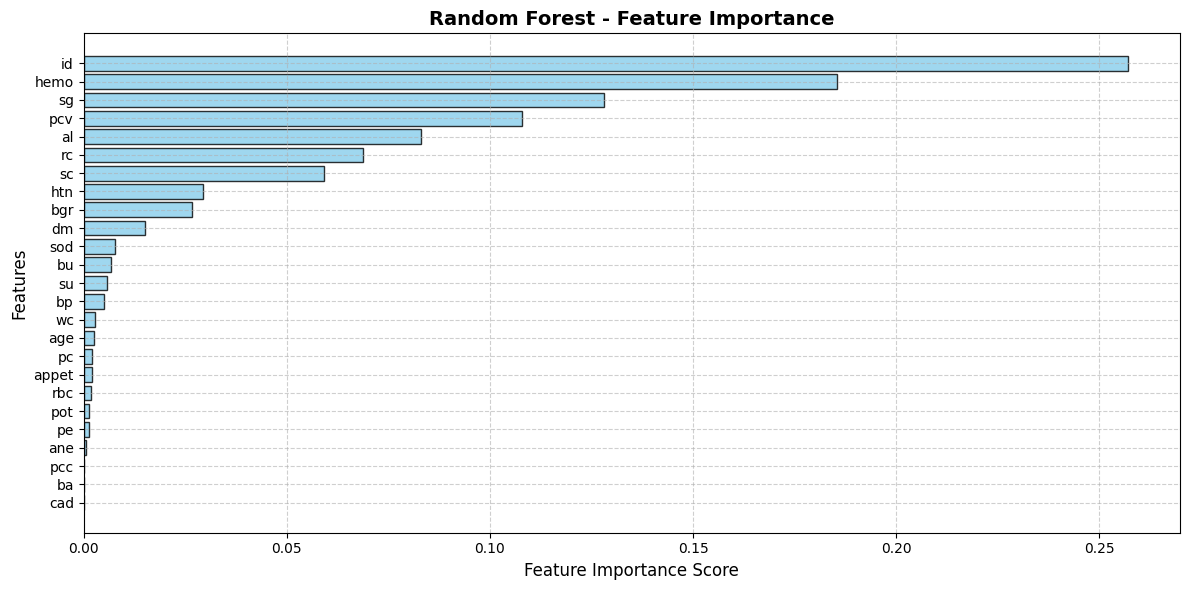

In [116]:
# Feature Importance for Random Forest
feature_importance = models["Random Forest"].feature_importances_  # Ensure model reference
features = X_k_train.columns  # Ensure correct feature column reference

# Plot settings
plt.figure(figsize=(12, 6))  # Increased figure size for better visualization
indices = np.argsort(feature_importance)[::-1]  # Sort features by importance (descending)

# Adjust bar width and color for clarity
plt.barh(features[indices], feature_importance[indices], color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Random Forest - Feature Importance", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Ensures most important features are at the top
plt.grid(True, linestyle="--", alpha=0.6)  # Add a subtle grid for readability
plt.tight_layout()  # Optimizes spacing
plt.show()

In [117]:
import pickle

# Save the trained Liver Disease Prediction model
with open("Kidney_prediction_model.pkl", "wb") as file:
    pickle.dump(models["XGBoost"], file)